In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from ruler_generator import RulerGenerator, merge_images
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

np_config.enable_numpy_behavior()

2023-04-22 19:29:59.245814: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 19:29:59.247213: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 19:29:59.277814: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 19:29:59.278306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 19:29:59.747468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
list_ds = tf.data.Dataset.list_files('data/Sketches/input_data/*')

2023-04-22 19:30:00.479194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-22 19:30:00.479782: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def get_image(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [4]:
def add_lines(image):
    image = (image*255)
    color_shift = np.clip(np.random.uniform(.8, 1.1, 3), 0,1)
    i = image = (image*color_shift).astype('uint8')
    image = Image.fromarray(image.numpy())
    image = ImageEnhance.Contrast(image).enhance(2)
    i_size = image.size
    
    kwargs = {'shape': i_size,
  'line_width': np.random.randint(1,4),
  'lines': np.random.randint(15,40),
  'v_offset': np.random.random(),
  'raggedness': .3 + np.random.random()/2,
  'color': np.random.randint(200, 256),
  'color_variation': np.random.randint(-15, 16),
  'angle': np.random.randint(-10, 11)}
    rg = RulerGenerator(**kwargs)
    image = Image.blend(image, rg.image, .2)
    
    return image, i

def tf_add_lines(image):
    [j,i] = tf.py_function(add_lines, [image],[tf.uint8, tf.uint8])# [tf.float32, tf.float32])
    j = tf.math.divide(j, 255)
    i = tf.math.divide(i,255)
    
    return j, i

2023-04-22 19:32:54.447932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:32:54.448051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


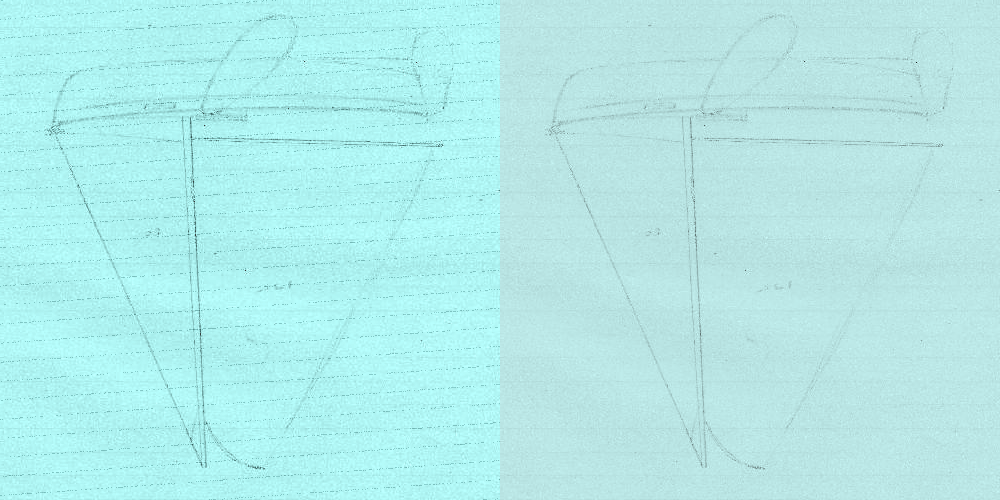

In [27]:
image_ds = list_ds.map(get_image)
image_ds = image_ds.map(tf.image.random_flip_left_right)
image_ds = image_ds.map(tf.image.random_flip_up_down)
train_ds = image_ds.map(tf_add_lines)
x, y = next(iter(train_ds.take(1)))
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=40)
train_ds = train_ds.batch(4)
merge_images(Image.fromarray((x.numpy()*255).astype('uint8')),
             Image.fromarray((y.numpy()*255).astype('uint8')))


In [28]:
n=32
model = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same'),
#       layers.Dense(3, activation='linear'),
#       layers.Reshape((500,500,3))
#       layers.Activation('linear')
])

model.compile(optimizer='adam', loss=losses.MeanSquaredError())
model.fit(train_ds, steps_per_epoch=1, epochs=1)
model.summary()

2023-04-22 19:32:55.020238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-22 19:32:55.020446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 3s 3s/step - loss: 0.1625
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 250, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 250, 250, 32)     9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 500, 500, 64)     18496     
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 500, 500, 3)       1731      
                                                       

In [ ]:
history = model.fit(train_ds, steps_per_epoch=10, epochs=100)

Epoch 1/100
10/10 [==============================] - 5s 313ms/step - loss: 0.0128
Epoch 2/100
10/10 [==============================] - 3s 315ms/step - loss: 0.0110
Epoch 3/100
10/10 [==============================] - 3s 315ms/step - loss: 0.0133
Epoch 4/100
10/10 [==============================] - 3s 315ms/step - loss: 0.0103
Epoch 5/100
10/10 [==============================] - 3s 312ms/step - loss: 0.0092
Epoch 6/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0110
Epoch 7/100
10/10 [==============================] - 3s 319ms/step - loss: 0.0078
Epoch 8/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0079
Epoch 9/100
10/10 [==============================] - 3s 321ms/step - loss: 0.0089
Epoch 10/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0107
Epoch 11/100
10/10 [==============================] - 3s 318ms/step - loss: 0.0085
Epoch 12/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0101
Epoch 13/100


10/10 [==============================] - 3s 340ms/step - loss: 0.0067
Epoch 100/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0045

In [ ]:
[plt.plot(v, label=k) for k,v in history.history.items()]
plt.legend();

In [ ]:
for i in train_ds.take(1).as_numpy_iterator():
    x, y = i
    y = y[0]
    
merge_images(Image.fromarray(((y)*255).astype('uint8')),
Image.fromarray((model.predict(x)[0]*255).astype('uint8')))

In [ ]:
val = np.random.choice([i for i in os.listdir('data/Sketches/Ruled/') if '.jpg' in i])
print(val)
val = Image.open('data/Sketches/Ruled/'+val).convert('RGB').resize((500,500))
val_X = (np.array(val)/255).reshape(-1,500,500,3)
# val_Y = (autoencoder.predict(val_X)[0]*255).astype('uint8')
val_Z = (model.predict(val_X)[0]*255).astype('uint8')
merge(merge(val, Image.fromarray(val_Y)), Image.fromarray(val_Z))